# Estimate the historic mining area of a single mine

In this notebook, the sam-geo model will be used to analyze the historic mining area of a single mine. 

### TODOs: 
- [ ] Plot sentinel images and masks yearly
- [ ] Add metadata (year) and different colors to polygons displayed on map
- [ ] Plot the area for each year
- [ ] Regularize very small polygons (?) 
- [ ] Test with landsat images as well to have larger timewindow
- [ ] Use segmentation polygon as input for previous year

In [1]:
# !pip install segment-geospatial

In [2]:
import sys
sys.path.append("..")

from samgeo import SamGeo
import leafmap
from matplotlib.pyplot import cm

from src.data.get_sentinel_images import ReadSTAC

In [3]:
MINE_POINT = [-50.16556135114535, -6.060451692157381]
BUFFER = 5
YEARS = list(range(2018, 2023))
print(YEARS)

[2018, 2019, 2020, 2021, 2022]


In [4]:
# Option 1 (Default): Read from Planetary Computer STAC API
# api_url="https://planetarycomputer.microsoft.com/api/stac/v1"
# bands = ['B04', 'B03', 'B02']

# Option 2: Read from AWS STAC API
api_url="https://earth-search.aws.element84.com/v1"
bands = ['red', 'green', 'blue']

stac_reader = ReadSTAC(api_url=api_url)

In [5]:
# Docs: https://samgeo.gishub.org/samgeo/#samgeo.samgeo.SamGeo.__init__
sam = SamGeo(
    model_type="vit_b", # vit_l (2.4GB), vit_h (1.2GB), vit_b(~300MB)
    automatic=False,
    # device="cuda",
    sam_kwargs=None,
)

# Optional: Use bounding box instead of point as prompt for SAM

In [6]:
# initiazlize leafmap and optionally draw a bounding box
m = leafmap.Map(center = [MINE_POINT[1], MINE_POINT[0]], zoom = 13, height="800px")
m.add_basemap("SATELLITE")
m

Map(center=[-6.060451692157381, -50.16556135114535], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [13]:
if m.user_rois is not None:
    sam_prompt_box = m.user_rois
    sam_prompt_point = None
else: 
    sam_prompt_box = None
    sam_prompt_point = [MINE_POINT]

print("Prompt Box:", sam_prompt_box)
print("Prompt Point:", sam_prompt_point)

Prompt Box: {'type': 'FeatureCollection', 'features': [{'type': 'Feature', 'properties': {}, 'geometry': {'type': 'Polygon', 'coordinates': [[[-50.207176, -6.118878], [-50.207176, -6.017312], [-50.107613, -6.017312], [-50.107613, -6.118878], [-50.207176, -6.118878]]]}}]}
Prompt Point: None


In [14]:
for year in YEARS:
    print(f"Year: {year}")

    # check available items
    items = stac_reader.get_items(
        location = MINE_POINT,
        buffer=10,
        timerange=f'{year}-01-01/{year}-12-31',
        max_cloud_cover=10
    )

    # download least cloudy image
    stack = stac_reader.get_stack(items, filter_by="least_cloudy", bands=bands, resolution=10)
    stack_stretched = stac_reader.stretch_contrast_stack(stack)
    image_path = stac_reader.save_stack_as_geotiff(stack_stretched, f"least_cloudy_{year}.tif")

    # provide image to samgeo
    sam.set_image(image_path)

    # create output file path for mask
    mask_path = image_path.replace(".tif", "_mask.tif")

    # predict mask
    sam.predict(
        point_coords=sam_prompt_point,
        boxes=sam_prompt_box, 
        point_labels=1, 
        point_crs="EPSG:4326", 
        output=mask_path
    )

    # convert mask to polygons
    mask_polygon_path = mask_path.replace(".tif", ".gpkg")
    sam.raster_to_vector(mask_path, mask_polygon_path)

    # add mask to map
    style = {
        "color": "#3388ff",
        "weight": 2,
        "fillColor": "#7c4185",
        "fillOpacity": 0.5,
    }
    m.add_vector(mask_polygon_path, layer_name=f"{year} Mask", style=style)


Year: 2018
18 Items found.
Loading stack...
Found 2 unique MGRS tiles.
For MGRS Tile MGRS-22MFU, choosing S2B_22MFU_20180720_0_L2A from 2018-07-20 with 0.023318% cloud cover
For MGRS Tile MGRS-22MEU, choosing S2B_22MEU_20180720_1_L2A from 2018-07-20 with 0.000201% cloud cover
Stretching contrast...
Saving stack as GeoTIFF under: /workspaces/mine-segmentation/data/interim/least_cloudy_2018.tif.tif
Year: 2019
30 Items found.
Loading stack...
Found 2 unique MGRS tiles.
For MGRS Tile MGRS-22MFU, choosing S2A_22MFU_20190730_0_L2A from 2019-07-30 with 0.009028% cloud cover
For MGRS Tile MGRS-22MEU, choosing S2A_22MEU_20190809_0_L2A from 2019-08-09 with 0.008803% cloud cover
Stretching contrast...
Saving stack as GeoTIFF under: /workspaces/mine-segmentation/data/interim/least_cloudy_2019.tif.tif
Year: 2020
54 Items found.
Loading stack...
Found 2 unique MGRS tiles.
For MGRS Tile MGRS-22MFU, choosing S2A_22MFU_20200614_1_L2A from 2020-06-14 with 0.000766% cloud cover
For MGRS Tile MGRS-22MEU, 

In [15]:
# display the map
m

Map(bottom=1084347.0, center=[-6.060451692157381, -50.16556135114535], controls=(ZoomControl(options=['positio…

['/workspaces/mine-segmentation/data/interim/least_cloudy_2018.tif', '/workspaces/mine-segmentation/data/interim/least_cloudy_2019.tif', '/workspaces/mine-segmentation/data/interim/least_cloudy_2020.tif', '/workspaces/mine-segmentation/data/interim/least_cloudy_2021.tif', '/workspaces/mine-segmentation/data/interim/least_cloudy_2022.tif']


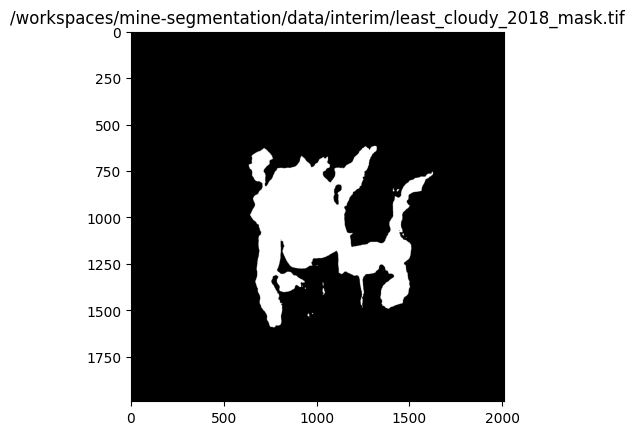

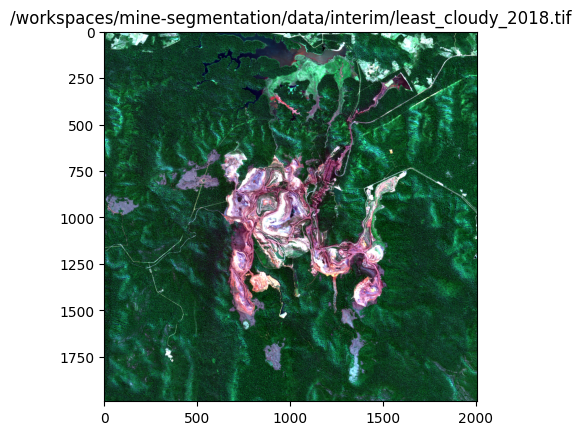

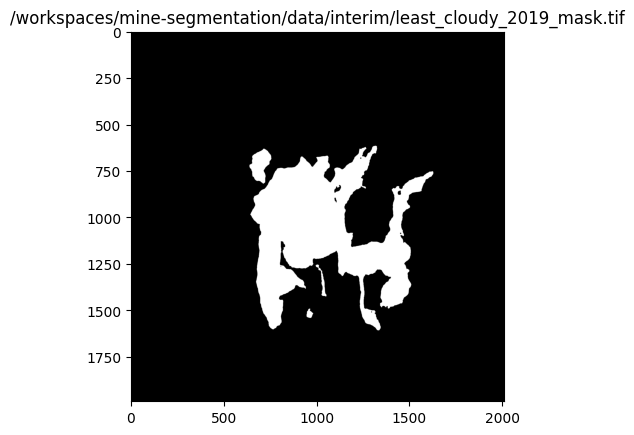

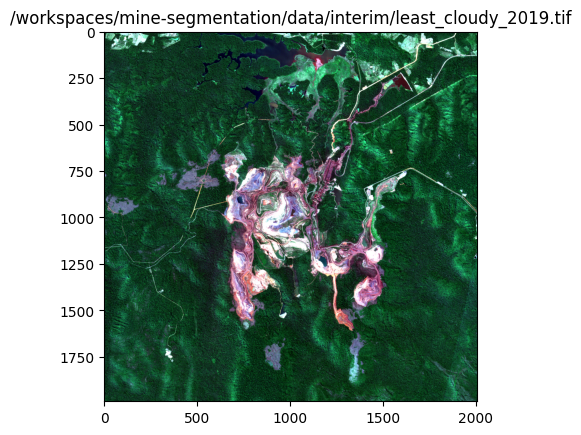

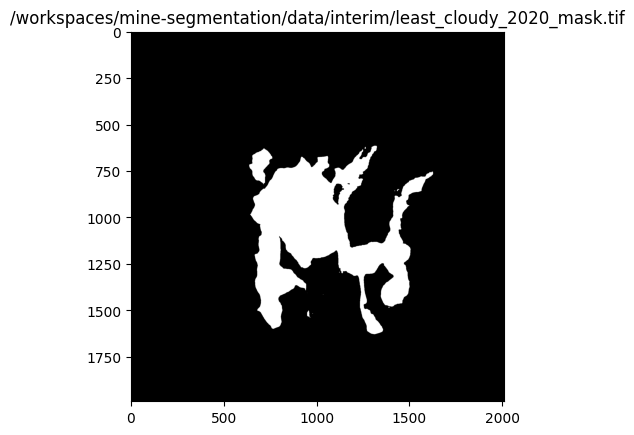

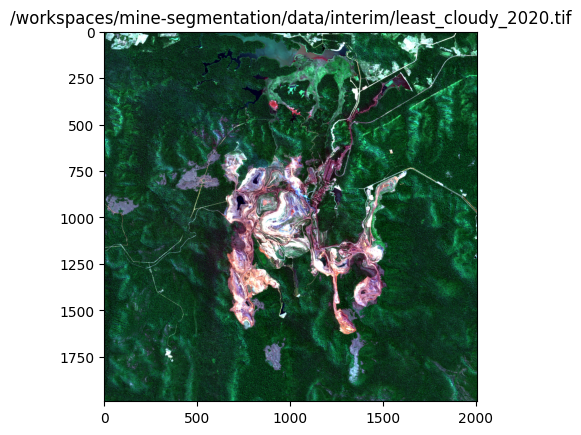

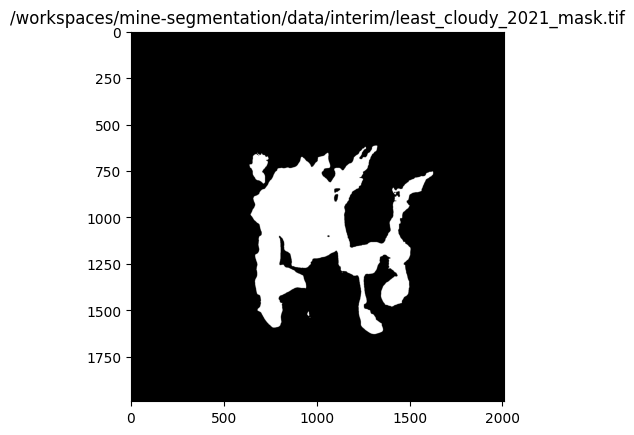

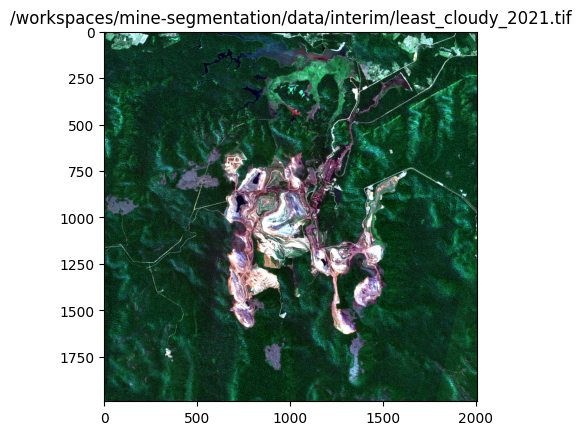

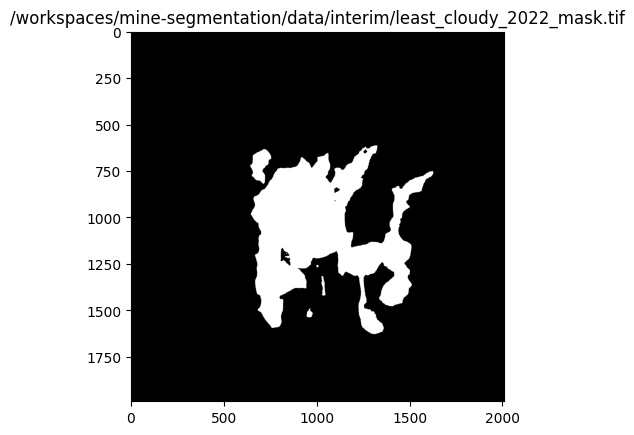

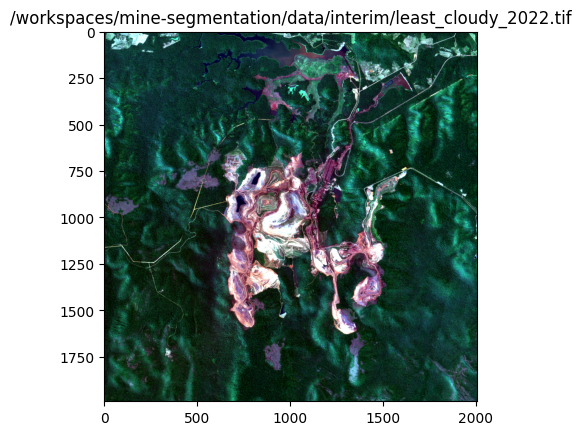

In [21]:
# Plot the masks
import glob
import matplotlib.pyplot as plt

mask_files = glob.glob('/workspaces/mine-segmentation/data/interim/*_mask.tif')

# Find all files ending with .tif in the folder data/interim
# and filter out files that contain "mask" in their name
image_files = glob.glob('/workspaces/mine-segmentation/data/interim/*.tif')
image_files = [file for file in image_files if "mask" not in file]

# Plot each mask file
for i, file in enumerate(mask_files):
    mask_file = mask_files[i]
    image_file = image_files[i]

    # Plot the mask
    mask = plt.imread(mask_file)
    plt.imshow(mask)
    plt.title(mask_file)
    plt.show()

    # Plot the image
    image = plt.imread(image_file)
    plt.imshow(image)
    plt.title(image_file)
    plt.show()

In [ ]:
# Plot the area development over time
mask_files[0]

'/workspaces/mine-segmentation/data/interim/S2A_22MEU_20190809_0_L2A_mask.tif'